In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/unsupervised_aav2`


In [2]:
using JLD2, BSON, Flux, PhageTree, PyPlot, BioSeqInt, Statistics, LinearAlgebra, StringDistances, DensityPlot, GaussianMixtures, Distributions

In [60]:
include("../analysis/utils.jl")

binomial_threshold (generic function with 1 method)

# Data
### CNN data are filtered (<100 counts)
Since the experimental threshold is determind by a fit, and this is performed with and expectation maximization procedure the value is not precisely the same if repeated (although the discrepancy is ininfluent). To make sure that the user is able to reproduce the exact same number from the article that fitted threshold values are attached as literals

In [4]:
threshold_experiment1 = -1.4792505511322604

-1.4792505511322604

In [5]:
threshold_experiment2 = -0.1828115693971919

-0.1828115693971919

In [6]:
sequences_experiment1, counts_experiment1, labels_experiment1 = 
    load_data_cnn("../my_data/data_experiment1.jld2", threshold_experiment1, "experiment1");

In [7]:
sequences_experiment2, counts_experiment2, labels_experiment2 = 
    load_data_cnn("../my_data/data_experiment2.jld2",threshold_experiment2, "experiment2");

In [8]:
data_experiment1 = load_data_phagetree("../my_data/data_experiment1.jld2", "experiment1");

In [9]:
data_experiment2 = load_data_phagetree("../my_data/data_experiment2.jld2", "experiment2");

In [10]:
findall(sum(data_experiment2.counts, dims=2) .== 0)

1-element Vector{CartesianIndex{2}}:
 CartesianIndex(22240, 1)

# log-selectivity

In [11]:
θexperiment1 = [log(counts_experiment1[m,2] / counts_experiment1[m,1]) for m in axes(counts_experiment1, 1)];

In [12]:
θexperiment2 = [log(counts_experiment2[m,2] / counts_experiment2[m,1]) for m in axes(counts_experiment2, 1)];

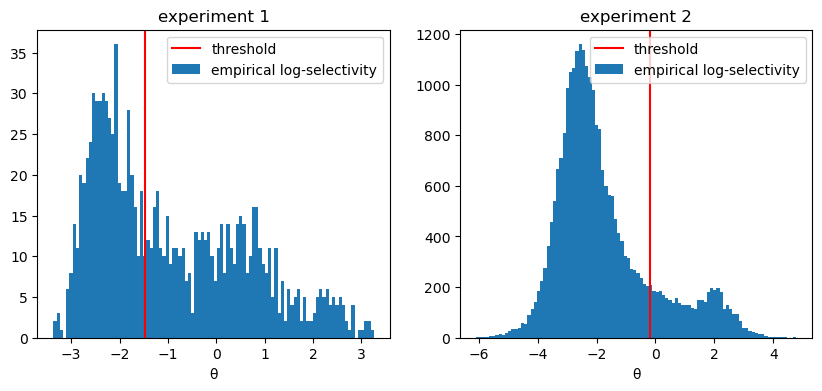

PyObject <matplotlib.legend.Legend object at 0x7fbdc12cdcd0>

In [13]:
fig, ax = subplots(1,2, figsize=(10,4))
ax[1].axvline(threshold_experiment1, color="red")
ax[1].hist(filter(isfinite, θexperiment1), bins=100)
ax[1].set_xlabel("θ")
ax[1].set_title("experiment 1")
ax[1].legend(["threshold", "empirical log-selectivity"])

ax[2].axvline(threshold_experiment2, color="red")
ax[2].hist(filter(isfinite, θexperiment2), bins=100)
ax[2].set_xlabel("θ")
ax[2].set_title("experiment 2")
ax[2].legend(["threshold", "empirical log-selectivity"])

# CNN

In [14]:
file_cnn = BSON.load("../cnn_models/train_experiment1_thrfit.bson")
model_cnn = file_cnn[:model]
history_cnn = file_cnn[:history]

MVHistory{ValueHistories.History}
  :training_loss => 200 elements {Int64,Float32}

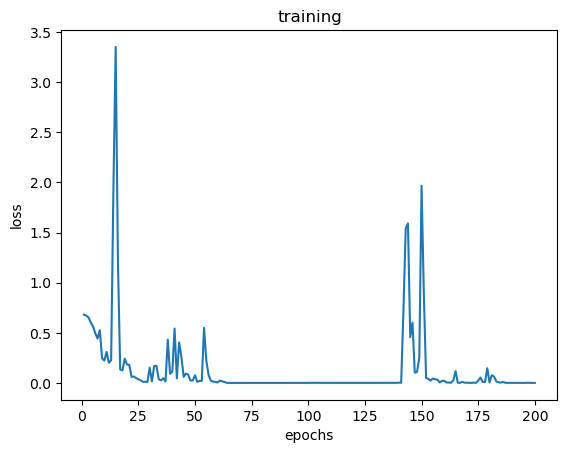

In [15]:
plot(get(history_cnn, :training_loss)...)
title("training")
xlabel("epochs")
ylabel("loss");

In [16]:
logits_experiment1 = model_cnn(sequences_experiment1) |> x -> x[2,:] .- x[1,:];

In [17]:
logits_experiment2 = model_cnn(sequences_experiment2) |> x -> x[2,:] .- x[1,:];

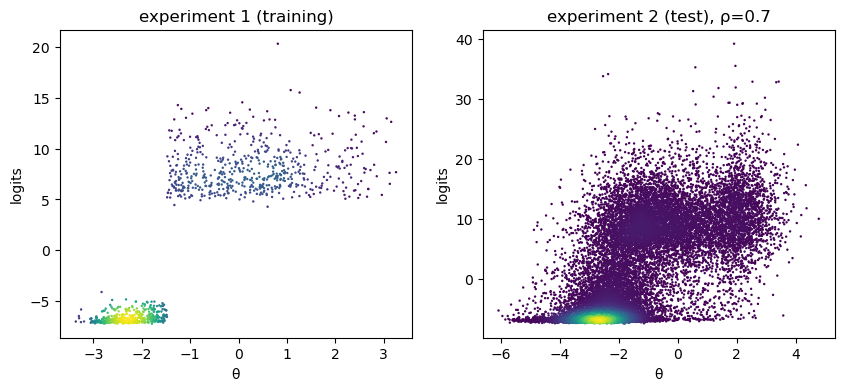

In [18]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiment1, logits_experiment1, ax[1], filter=false)
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("logits");

plot_density(θexperiment2, logits_experiment2, ax[2], filter=true)
ax[2].set_title("experiment 2 (test), ρ=$(round(cor_sp(θexperiment2, logits_experiment2), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("logits");

In [19]:
println("training accuracy: ",
compute_accuracy(logits_experiment1, 0.0, θexperiment1, threshold_experiment1))

training accuracy: 1.0


In [20]:
println("test accuracy: ",
compute_accuracy(logits_experiment2, 0.0, θexperiment2, threshold_experiment2))

test accuracy: 0.7950503292212215


In [21]:
true_pos_cnn, false_pos_cnn = roc(logits_experiment2, θexperiment2, threshold_experiment2);

In [22]:
auc_val_cnn = auc(false_pos_cnn, true_pos_cnn) |> mean
println("AUC: ", auc_val_cnn)

AUC: 0.8920343629107912


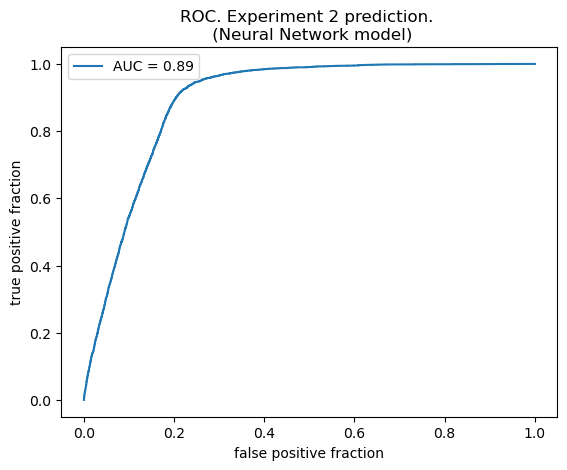

PyObject <matplotlib.legend.Legend object at 0x7fbdc08f6d90>

In [23]:
plot(false_pos_cnn, true_pos_cnn)
title("ROC. Experiment 2 prediction. \n (Neural Network model)")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_cnn, digits=2))"])

In [52]:
println("confusion matrix \n")
confusion_matrix(logits_experiment2, 0.0, θexperiment2, threshold_experiment2)

confusion matrix 

TP: 4132	 FN: 286
FP: 5130	 TN: 16878

# PhageTree

In [25]:
file_phagetree = BSON.load("../phagetree_models/train_experiment1_b256_better.bson")
model_pt = file_phagetree[:model]
history_pt = file_phagetree[:history]

MVHistory{ValueHistories.History}
  :loglikelihood_batch => 3000 elements {Int64,Float64}
  :loglikelihood => 600 elements {Int64,Float64}
  :epoch => 3000 elements {Int64,Int64}

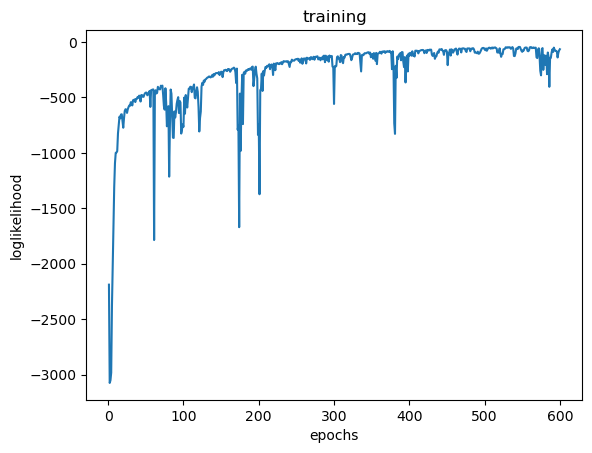

In [26]:
plot(get(history_pt, :loglikelihood)...)
title("training")
xlabel("epochs")
ylabel("loglikelihood");

In [27]:
ls_experiment1 = vec(log_selectivities(model_pt, data_experiment1));

In [28]:
ls_experiment2 = vec(log_selectivities(model_pt, data_experiment2))
ls_experiment2_filtered = ls_experiment2[data_experiment2.counts[:,1].>=100];

In [29]:
θexperiment1_pt = vec(log_selectivities(data_experiment1));

In [30]:
θexperiment2_pt = vec(log_selectivities(data_experiment2));

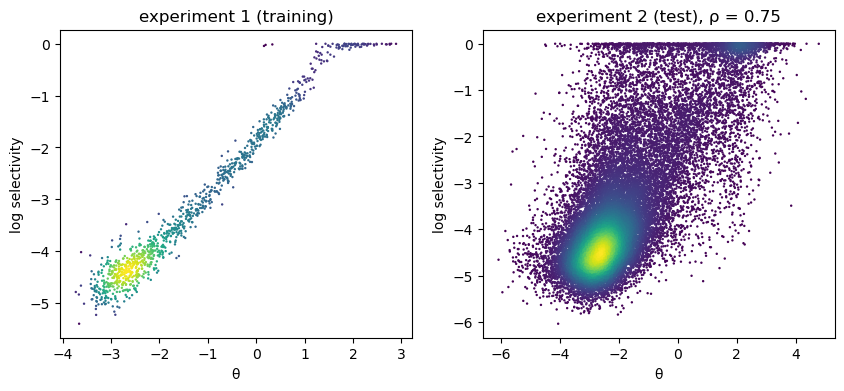

PyObject Text(446.72727272727263, 0.5, 'log selectivity')

In [31]:
fig, ax = subplots(1,2, figsize=(10,4))

plot_density(θexperiment1_pt, ls_experiment1, ax[1])
ax[1].set_title("experiment 1 (training)")
ax[1].set_xlabel("θ")
ax[1].set_ylabel("log selectivity")

plot_density(θexperiment2, ls_experiment2_filtered, ax[2], filter=true)
ax[2].set_title("experiment 2 (test), ρ = $(round(cor_sp(θexperiment2, ls_experiment2_filtered), digits=2))")
ax[2].set_xlabel("θ")
ax[2].set_ylabel("log selectivity")

In [32]:
true_pos_pt, false_pos_pt = roc(ls_experiment2_filtered, θexperiment2, threshold_experiment2);

In [33]:
auc_val_pt = auc(false_pos_pt, true_pos_pt) |> mean
println("AUC: ", auc_val_pt)

AUC: 0.9311918387140675


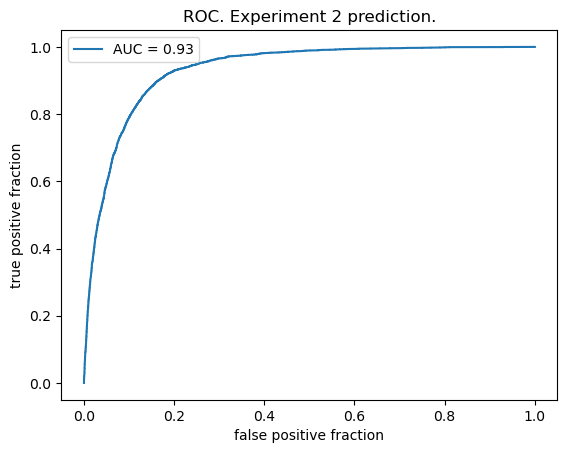

PyObject <matplotlib.legend.Legend object at 0x7fbdb0be5850>

In [34]:
plot(false_pos_pt, true_pos_pt)
title("ROC. Experiment 2 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["AUC = $(round(auc_val_pt, digits=2))"])

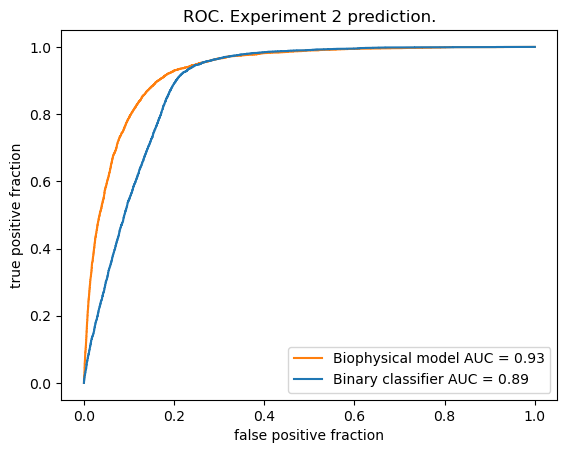

In [75]:
plot(false_pos_pt, true_pos_pt, color="#ff7f0e")
plot(false_pos_cnn, true_pos_cnn, color="#1f77b4")
title("ROC. Experiment 2 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["Biophysical model AUC = $(round(auc_val_pt, digits=2))", "Binary classifier AUC = $(round(auc_val_cnn, digits=2))"])
savefig("../figures/exp2_roc.pdf", format="pdf")

In [36]:
ls_threshold = optimal_threshold(ls_experiment2_filtered, true_pos_pt, false_pos_pt)

-2.7973821593263573

In [37]:
println("test accuracy: ",
compute_accuracy(ls_experiment2_filtered, ls_threshold, θexperiment2, threshold_experiment2))

test accuracy: 0.849693483690305


In [66]:
println("confusion matrix \n")
confusion_mat_gscore_exp2=confusion_matrix(ls_experiment2_filtered, ls_threshold, θexperiment2, threshold_experiment2)

confusion matrix 

TP: 3955	 FN: 463
FP: 3509	 TN: 18499

(tpr = 0.8952014486192847, fpr = 0.15944202108324246)

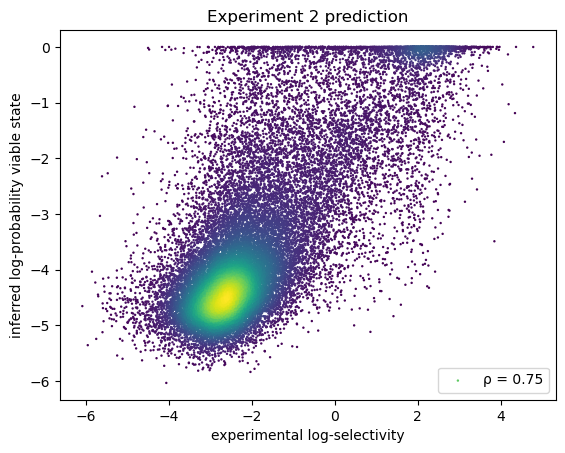

In [74]:
plot_density(θexperiment2, ls_experiment2_filtered, filter=true)
title("Experiment 2 prediction")
xlabel("experimental log-selectivity")
ylabel("inferred log-probability viable state")
legend(["ρ = $(round(cor_sp(θexperiment2, ls_experiment2_filtered), digits=2))"])
savefig("../figures/exp2_prediction.pdf", format="pdf")

### Choosing the threshold in an unsupervised manner

In [40]:
energies_exp1 = energies(data_experiment1.sequences, model_pt.states[2])
energies_exp2 = energies(data_experiment2.sequences[:,:,data_experiment2.counts[:,1].>= 100], model_pt.states[2]);

In [41]:
μeff = model_pt.μ[2,1] - model_pt.μ[1,1]

0.009192245092378244

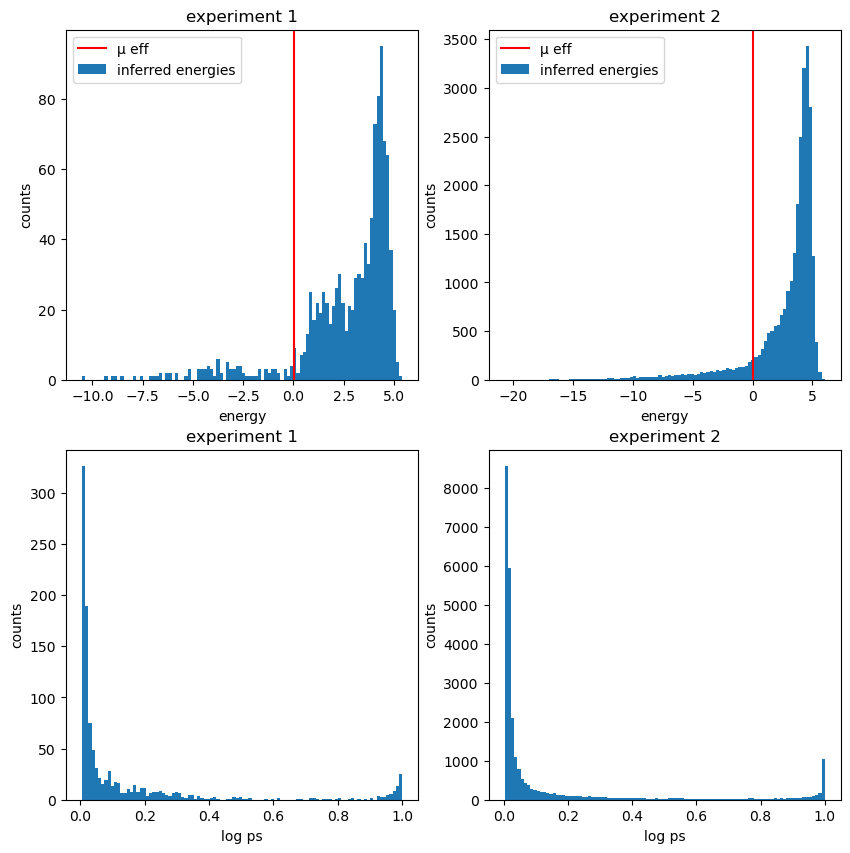

In [42]:
fig, ax = subplots(2,2, figsize=(10,10))
ax[1,1].axvline(μeff, color="red")
ax[1,1].hist(energies_exp1, bins=100)
ax[1,1].set_xlabel("energy")
ax[1,1].set_ylabel("counts")
ax[1,1].set_title("experiment 1")
ax[1,1].legend(["μ eff", "inferred energies"])

ax[1,2].axvline(μeff, color="red")
ax[1,2].hist(energies_exp2, bins=100)
ax[1,2].set_xlabel("energy")
ax[1,2].set_ylabel("counts")
ax[1,2].set_title("experiment 2")
ax[1,2].legend(["μ eff", "inferred energies"])

ax[2,1].hist(exp.(ls_experiment1), bins=100)
ax[2,1].set_xlabel("log ps")
ax[2,1].set_ylabel("counts")
ax[2,1].set_title("experiment 1")

ax[2,2].hist(exp.(ls_experiment2_filtered), bins=100)
ax[2,2].set_xlabel("log ps")
ax[2,2].set_ylabel("counts")
ax[2,2].set_title("experiment 2");

In [43]:
gmm = GMM(2,1)
gmm.μ .+= randn(2,1)
gmm.Σ .*= 1e-1;

In [44]:
em!(gmm, Float64.(reshape(energies_exp2, :, 1)); nIter=120)

120-element Vector{Float64}:
 -Inf
  -2.0781320487038495
  -2.047986824187104
  -2.0294535529135707
  -2.0158544741534286
  -2.005495095449325
  -1.99731270920254
  -1.990653672868254
  -1.9851324551982699
  -1.9805265362951234
  -1.9767016880337587
  -1.9735638604443309
  -1.9710322462121854
   ⋮
  -1.9629655764833684
  -1.9629655764833709
  -1.9629655764833684
  -1.9629655764833676
  -1.9629655764833673
  -1.9629655764833713
  -1.9629655764833698
  -1.9629655764833678
  -1.9629655764833682
  -1.9629655764833678
  -1.9629655764833693
  -1.9629655764833673

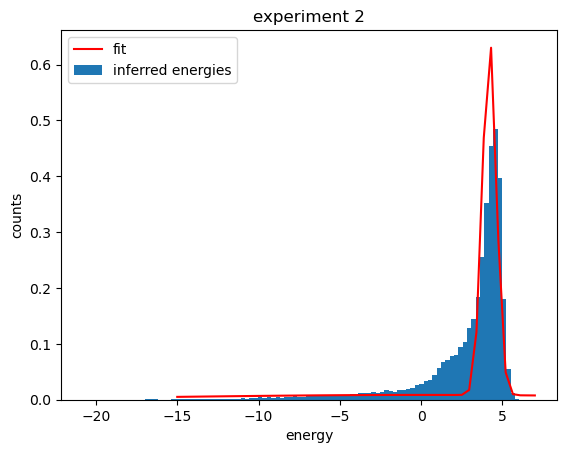

PyObject Text(0.5, 1.0, 'experiment 2')

In [54]:
xx = LinRange(-15.0, 7.0, 50)
hist(energies_exp2, bins=100, density=true)
plot(xx, eval_gmm(gmm, xx), color="red")
xlabel("energy")
ylabel("counts")
legend(["fit", "inferred energies"])
title("experiment 2")

In [55]:
function find_valley(gmm, resolution::Int)
    xmin = gmm.μ[1,1]
    xmax = gmm.μ[2,1]
    r = LinRange(xmin, xmax, resolution)
    y = eval_gmm(gmm, r)
    xvalley = argmin(y)
    return r[xvalley]
end

find_valley (generic function with 1 method)

In [56]:
find_valley(gmm, 100)

2.1865914486254234

In [57]:
unsupervised_energy_threshold = 2.186591448464858

2.186591448464858

In [58]:
println("testing accuracy on experiment 2: ",
compute_accuracy(-energies_exp2, -unsupervised_energy_threshold, θexperiment2, threshold_experiment2))

testing accuracy on experiment 2: 0.8758798153333838


In [62]:
println("confusion matrix \n")
confusion_mat_unsupervised_exp2 = confusion_matrix(-energies_exp2, -unsupervised_energy_threshold, θexperiment2, threshold_experiment2)

confusion matrix 

TP: 3612	 FN: 806
FP: 2474	 TN: 19534

(tpr = 0.8175645088275237, fpr = 0.1124136677571792)

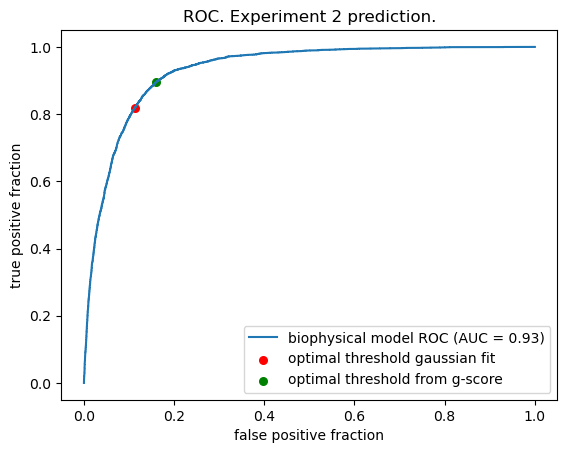

In [94]:
plot(false_pos_pt, true_pos_pt)
scatter([confusion_mat_unsupervised_exp2.fpr], [confusion_mat_unsupervised_exp2.tpr], s=30, color="red")
scatter([confusion_mat_gscore_exp2.fpr], [confusion_mat_gscore_exp2.tpr], s=30, color="green")
title("ROC. Experiment 2 prediction.")
xlabel("false positive fraction")
ylabel("true positive fraction")
legend(["biophysical model ROC (AUC = $(round(auc_val_pt, digits=2)))", "optimal threshold gaussian fit", "optimal threshold from g-score"])
savefig("../figures/exp2_roc_points.pdf", format="pdf")

# Distance analysis

In [76]:
file_exp1 = load("../my_data/data_experiment1.jld2")

Dict{String, Any} with 3 entries:
  "wt_aa"                 => "DEEEIRTTNPVATEQYGSVSTNLQRGNR"
  "sequences_experiment1" => ["DEELIRTTNPVATEQYGSVSTNLQRGNR", "DEEEIYTTNPVATEQY…
  "counts_experiment1"    => [1439 349; 2829 3326; … ; 2053 6849; 4249 409]

In [77]:
wt_aa = file_exp1["wt_aa"]

"DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [78]:
sequences_string_experiment2 = onehot2string(sequences_experiment2, channel=true);

In [79]:
distances_cnn = map(x->evaluate(Levenshtein(), x, wt_aa), sequences_string_experiment2);

In [80]:
dmin, dmax = extrema(distances_cnn)

(1, 30)

In [81]:
accuracy_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        accuracy_distance[i] = NaN
        continue
    end
    accuracy_distance[i] = compute_accuracy(logits_experiment2[idx], 0.0, θexperiment2[idx], threshold_experiment2)
end

In [89]:
accuracy_distance_energy = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        accuracy_distance_energy[i] = NaN
        continue
    end
    accuracy_distance_energy[i] = compute_accuracy(-energies_exp2[idx], -unsupervised_energy_threshold, 
        θexperiment2[idx], threshold_experiment2)
end

In [90]:
pearson_distance = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        pearson_distance[i] = NaN
        continue
    end
    pearson_distance[i] = cor_sp(θexperiment2[idx], ls_experiment2_filtered[idx])
end

In [91]:
viable_frac = zeros(dmax - dmin +1)
for (i, d) in pairs(dmin:1:dmax)
    idx = findall(distances_cnn .== d)
    if length(idx) < 50
        viable_frac[i] = NaN
        continue
    end
    viable_frac[i] = sum(θexperiment2[idx] .>= threshold_experiment2)/length(idx)
end

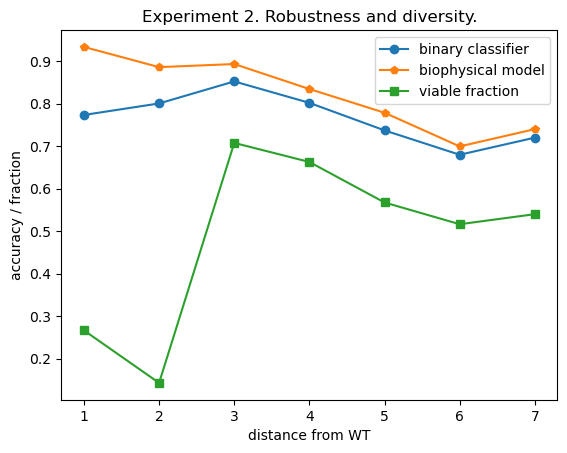

In [92]:
plot(dmin:dmax, accuracy_distance, marker="o")
plot(dmin:dmax, accuracy_distance_energy, marker="p")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["binary classifier", "biophysical model", "viable fraction"])
ylabel("accuracy / fraction")
xlabel("distance from WT")
title("Experiment 2. Robustness and diversity.")
savefig("../figures/exp2_distance_accuracy.pdf", format="pdf")

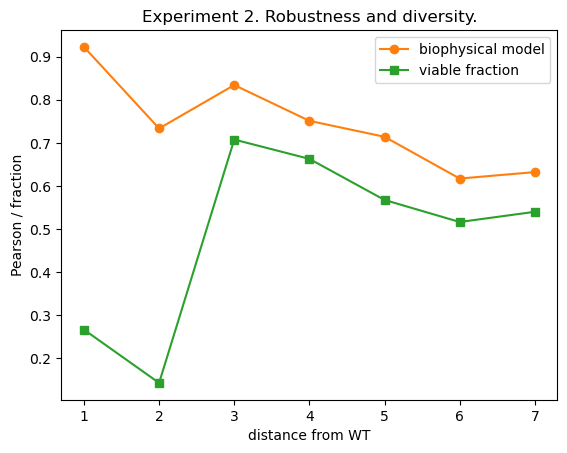

In [93]:
plot(dmin:dmax, pearson_distance, marker="o", color="#ff7f0e")
plot(dmin:dmax, viable_frac, marker="s", color="#2ca02c")
legend(["biophysical model", "viable fraction"])
ylabel("Pearson / fraction")
xlabel("distance from WT")
title("Experiment 2. Robustness and diversity.")
savefig("../figures/exp2_distance_pearson.pdf", format="pdf")